In [8]:
from astropy import coordinates as coord
from astropy import io
from astropy import units as u
from astropy.table import Table
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import binned_statistic_2d as bs2d
from Deproject_v1_0 import *
from fast_kde import fast_kde
import matplotlib.pyplot as plt
import os
import numpy as np

plt.style.use('classic')

## Playing with GDR2 data

In [9]:
del data_raw

In [10]:
def calc_p_rhat(sample):

#Oort constant values from Bovy (2018)
    A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
    B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

    bvals = sample.b.to(u.deg)
    lvals = sample.l.to(u.deg)

    mul_obs = sample.pm_l_cosb.to(1/u.yr,equivalencies = u.dimensionless_angles())
    mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

    """Computation of the relevant quantities

        l,b: Galactic coordinates
        s: the distance obtained by inverting the parallax
        mul, mub: proper motion in l and b
        pvals: Tangential velocities obtained from eq. 2 in DB98
        rhatvals: The unit vector of each star
        vmin: Vector containing the minimum velocities in v-space
        n: The number of cells we want in each dimension of our v-space box
        dv: Step sizes for each dimension"""

    b = np.deg2rad(bvals).value
    l = np.deg2rad(lvals).value
    cosl = np.cos(l)
    cosb = np.cos(b)
    sinl = np.sin(l)
    sinb = np.sin(b)
    s = sample.distance

    mul = mul_obs - A*np.cos(2*l)-B
    mub = mub_obs + A*np.sin(2*l)*cosb*sinb

    pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                     cosl*cosb*mul - sinl*sinb*mub,
                     cosb*mub])/u.yr

    rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
    pvals = pvals.to(u.km/u.s).value.T
    
    return pvals, rhatvals 

In [11]:
#Initiation of data, now loading GRD1 data and setting up the various parameters used in the code below

os.chdir("/Users/danielmikkola/DeprojectionProject/DATA/")

try:
    data_raw
except NameError:
    data_raw = Table.read('gaiadr2_100pc_clean.fits')


try:
    RA = data_raw['ra']
    DEC = data_raw['dec']
    pm_RA = data_raw['pmra']
    pm_DEC = data_raw['pmdec']
    parallax_raw = data_raw['parallax'].to(u.mas)

    G_mean_raw = data_raw['phot_g_mean_mag'].to(u.mag)
    BP_RP_raw = data_raw['bp_rp'].to(u.mag)
    E_BP_RP = data_raw['e_bp_min_rp_val']
    phot_bp_mean_mag = data_raw['phot_bp_mean_mag']
    phot_rp_mean_mag = data_raw['phot_rp_mean_mag']

except KeyError:    
    RA = data_raw['RA']*u.deg
    DEC = data_raw['DEC']*u.deg
    pm_RA = data_raw['PMRA']*u.mas/u.yr
    pm_DEC = data_raw['PMDEC']*u.mas/u.yr
    parallax_raw = data_raw['PARALLAX']*u.mas

    G_mean_raw = data_raw['PHOT_G_MEAN_MAG']*u.mag
    BP_RP_raw = data_raw['BP_RP']*u.mag
    E_BP_RP = data_raw['E_BP_MIN_RP_VAL']
    phot_bp_mean_mag = data_raw['PHOT_BP_MEAN_MAG']
    phot_rp_mean_mag = data_raw['PHOT_RP_MEAN_MAG']
    pass

#Properties used for data selection

try:
    parallax_over_error = data_raw['parallax_over_error']
    phot_g_mean_flux_over_error = data_raw['phot_g_mean_flux_over_error']
    phot_rp_mean_flux_over_error = data_raw['phot_rp_mean_flux_over_error']
    phot_bp_mean_flux_over_error = data_raw['phot_bp_mean_flux_over_error']
    phot_bp_rp_excess_factor = data_raw['phot_bp_rp_excess_factor']
    visibility_periods_used = data_raw['visibility_periods_used']
    astrometric_chi2_al = data_raw['astrometric_chi2_al']
    astrometric_n_good_obs_al = data_raw['astrometric_n_good_obs_al']
except KeyError:
    parallax_over_error = data_raw['PARALLAX_OVER_ERROR']
    phot_g_mean_flux_over_error = data_raw['PHOT_G_MEAN_FLUX_OVER_ERROR']
    phot_rp_mean_flux_over_error = data_raw['PHOT_RP_MEAN_FLUX_OVER_ERROR']
    phot_bp_mean_flux_over_error = data_raw['PHOT_BP_MEAN_FLUX_OVER_ERROR']
    phot_bp_rp_excess_factor = data_raw['PHOT_BP_RP_EXCESS_FACTOR']
    visibility_periods_used = data_raw['VISIBILITY_PERIODS_USED']
    astrometric_chi2_al = data_raw['ASTROMETRIC_CHI2_AL']
    astrometric_n_good_obs_al = data_raw['ASTROMETRIC_N_GOOD_OBS_AL']

parallax_raw = parallax_raw.to(u.mas) #This is done to avoid having to deal with inconsitencies in units of the datasets
G_mean_raw = G_mean_raw.to(u.mag)
BP_RP_raw = BP_RP_raw.to(u.mag)

dist = parallax_raw.to(u.kpc,equivalencies=u.parallax())

sample_raw = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

sample_gc = sample_raw.transform_to(coord.Galactic)

We have our chosen set of data in Galactic coordinates $(l,b)$ and proceed to apply cuts to the data set in order to remove data points that carry high uncertainties.

We apply the following standard cuts which are provided in the [Observational HRD paper](https://ui.adsabs.harvard.edu/#abs/2018arXiv180409378G/abstract) of Gaia Collaboration et al (2018).

\begin{align}
&\texttt{parallax_over_error} > 10 \\
&\texttt{phot_g_mean_flux_over_error} > 50 \\
&\texttt{phot_rp_mean_flux_over_error} >20 \\
&\texttt{phot_bp_mean_flux_over_error} > 20 \\
&\texttt{phot_bp_rp_excess_factor} < 1.3+0.06*(\texttt{phot_bp_mean_mag}-\texttt{phot_rp_mean_mag})^2 \\
&\texttt{phot_bp_rp_excess_factor} > 1.0+0.015*(\texttt{phot_bp_mean_mag}-\texttt{phot_rp_mean_mag})^2 \\
&\texttt{visibility_periods_used} > 8 \\
&\texttt{astrometric_chi2_al}/(\texttt{astrometric_n_good_obs_al} -5 ) < 1.44*\texttt{max}(1,\exp(-0.4*\texttt{phot_g_mean_mag}-19.5)
\end{align}

These are all performed by default by the function $\texttt{apply_cuts}$ and are given in the variable $\texttt{standard_cuts}$. If additional cuts are desired, they can be provided in the argument $\texttt{additional_cuts}$.

In [15]:
#Data selection

def apply_cuts(sample,G_mean,BP_RP,additional_cuts=[]):
    
    idx_mask = np.in1d(sample_gc.b.value,sample.b.value)
    idx = np.argwhere(idx_mask).reshape(len(sample))
    
    if all(idx_mask):
        idx = None
        
    #The above code investigates if the sample we want to make cuts too is the raw original sample
    #or merely a subsample and thus saves the indices that the subsample is represented by
        
    chinu_raw = np.stack((np.exp(-0.4*(G_mean.value-19.5)), np.ones((G_mean.shape))),axis = 0)
    
    chinu = chinu_raw.reshape((2,len(sample)))

    """Next we perform the standard cuts which are provided in Appendix B of the Observational HR-Diagram paper of
        Gaia Collaboration et al (2018)"""

    standard_cuts = [parallax_over_error[idx]<10,visibility_periods_used[idx]<8,phot_g_mean_flux_over_error[idx]<50,\
               phot_rp_mean_flux_over_error[idx]<20,phot_bp_mean_flux_over_error[idx]<20,\
               phot_bp_rp_excess_factor[idx] > 1.3+0.06*(phot_bp_mean_mag[idx]-phot_rp_mean_mag[idx])**2,\
               phot_bp_rp_excess_factor[idx] < 1.0+0.015*(phot_bp_mean_mag[idx]-phot_rp_mean_mag[idx])**2,\
               astrometric_chi2_al[idx]/(astrometric_n_good_obs_al[idx]-5)>(1.44*np.amax(chinu,axis=0)).reshape((len(sample)))]

    """Additional cuts on e.g. distance, coordinates, tangential velocity etc. are provided in the addditional_cuts list"""
    ac_sliced=[]
    
    for i in additional_cuts:
        
        try:
            ac_sliced.append(i[idx])
        except IndexError:
            ac_sliced.append(i)
            continue
    
#     ac_sliced = [i[idx] for i in additional_cuts]
    
    try:
        cut_list = np.concatenate((standard_cuts,ac_sliced))
    except ValueError:
        cut_list = standard_cuts
        pass
    
    #We need to reshape the list of cuts for consistency with the np.argwhere command
    #We then obtain a list with indices of the 'bad' data points
    cut_list_rs = [np.reshape(i,(len(sample_raw))) for i in cut_list]
    bad_idx_list = [np.argwhere(i) for i in cut_list_rs]
    bad_idx_arr = np.concatenate(bad_idx_list)
    
    bad_idx_arr1 = bad_idx_arr.reshape((len(bad_idx_arr)))

    #Uncomment the three terms below and add take the unique values of bad_idx_arr2 instead of arr_1
    #if we want to use the data for an HRD plot
    
    nan_idx = np.concatenate([np.ravel(np.argwhere(np.isnan(G_mean_raw))),np.ravel(np.argwhere(np.isnan(BP_RP_raw)))]) 
    nanvals = np.unique(nan_idx)
    bad_idx_arr2 = np.concatenate([bad_idx_arr1,nanvals])

    bad_idx = np.unique(bad_idx_arr2)

    #We create a full array with the same shape as our raw sample that
    #contains True in every data point. We then set the bad index data
    #points to False and obtain a mask
    mask = np.full((sample_raw.shape),True)
    mask[bad_idx] = False

    sample = sample_raw[mask]
    G_mean_new = G_mean[mask]
    BP_RP_new = BP_RP[mask]
    
    return sample, G_mean_new, BP_RP_new

In [17]:
v_T_arr = calc_p_rhat(sample_gc)[0]
v_T = np.linalg.norm(v_T_arr,axis=1)

distance_cut = 0.05*u.kpc

ac = [sample_gc.distance>distance_cut]#,E_BP_RP>0.015] #N.B. We remove the stars that does not fulfill this criteria

sample, G_mean, BP_RP = apply_cuts(sample_gc,G_mean_raw,BP_RP_raw,additional_cuts=ac)

sample_gc.shape,sample.shape

/Users/danielmikkola/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/danielmikkola/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


((211738,), (29058,))

In [7]:
def plot_HRD(sample,G_mean,BP_RP):
    
    """Function that given a sample and its G and BP_RP magnitudes provides an H-R diagram with the density of stars
    provided using a colormap. The density is computed using a Gaussian KDE"""
    
    parallax = sample.distance.to(u.mas,equivalencies=u.parallax())
    
    Gvals = G_mean.value+5*np.log10(parallax.value)-10
    
    xmin = BP_RP.value.min()-0.2
    xmax = BP_RP.value.max()+0.2
    ymin = Gvals.min()-0.2
    ymax = Gvals.max()+0.2
    
    xbins = np.arange(BP_RP.value.min(),BP_RP.value.max()+0.1,0.1)
    ybins = np.arange(Gvals.min(),Gvals.max()+0.3,0.3)
    
#     xc = (xbins[1:]+xbins[:-1])/2
#     yc = (ybins[1:]+ybins[:-1])/2

    dsty = fast_kde(BP_RP,Gvals,sample=True)[2]
        
    idx = dsty.argsort()
    
    xvals, yvals, zvals = BP_RP[idx],Gvals[idx],dsty[idx]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('$\mathrm{HR-Diagram\ of\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    stars = ax.scatter(xvals,yvals,c=zvals,edgecolor='',s=5,cmap=plt.cm.get_cmap('inferno'))
    cb = plt.colorbar(stars)
    cb.set_label('$\mathrm{Number\ density\ of\ stars}$',size='large')
    
    plt.show()
    
    return

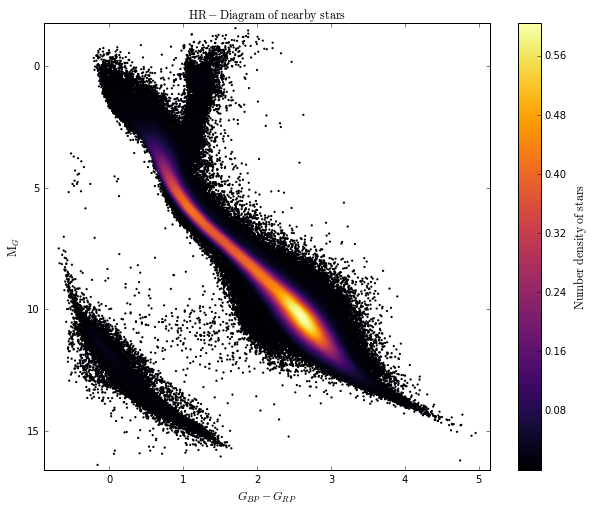

In [39]:
plot_HRD(sample,G_mean,BP_RP)

In [12]:
def plot_HRD_cut(sample,G_mean,BP_RP,base_sample=[]):
    
    """Function that given a sample and its G and BP_RP magnitudes provides an H-R diagram with the density of stars
    provided using a colormap. The density is computed using a Gaussian KDE"""
    
    parallax = sample.distance.to(u.mas,equivalencies=u.parallax())
    
    Gvals = G_mean.value+5*np.log10(parallax.value)-10
    
    xmin = BP_RP.value.min()-0.2
    xmax = BP_RP.value.max()+0.2
    ymin = Gvals.min()-0.2
    ymax = Gvals.max()+0.2
    
    xbins = np.arange(BP_RP.value.min(),BP_RP.value.max()+0.1,0.1)
    ybins = np.arange(Gvals.min(),Gvals.max()+0.3,0.3)
    
#     xc = (xbins[1:]+xbins[:-1])/2
#     yc = (ybins[1:]+ybins[:-1])/2

    dsty = fast_kde(BP_RP,Gvals,sample=True)[2] #We smooth the data using a Gaussian kernel density estimation function
        
    idx = dsty.argsort()
    
    #We sort the args to get the largest values on top in the scatter plot
    xvals, yvals, zvals = BP_RP[idx],Gvals[idx],dsty[idx]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('$\mathrm{HR-Diagram\ of\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    ax.plot([0.8,0.72],[3.8,4.2],'r-',lw=2)
    ax.plot([0.72,0.75],[4.2,4.8],'c-',lw=2)
    ax.plot([0.75,0.9],[4.8,5.6],'r-',lw=2)
    ax.plot([0.9,1.3],[5.6,6.8],'c-',lw=2)
    ax.plot([1.3,1.5],[6.8,7.3],'r-',lw=2)
    ax.plot([1.5,1.6],[7.3,7.6],'c-',lw=2)
    ax.plot([1.6,1.8],[7.6,8.2],'r-',lw=2)
    ax.plot([1.8,2.0],[8.2,8.6],'c-',lw=2)
    ax.plot([2.0,2.2],[8.6,9.3],'r-',lw=2)
    ax.plot([2.2,3.2],[9.3,13.0],'c-',lw=2)
    
    stars = ax.scatter(xvals,yvals,c=zvals,edgecolor='',s=5,cmap=plt.cm.get_cmap('inferno'))
    cb = plt.colorbar(stars)
    cb.set_label('$\mathrm{Number\ density\ of\ stars}$',size='large')
    
    plt.show()
    
    return

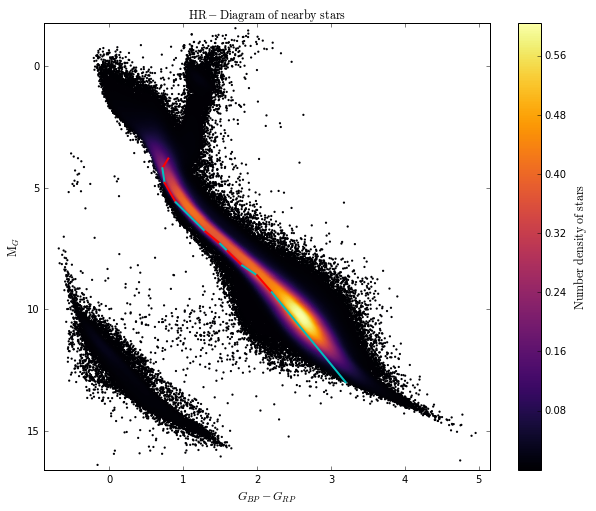

In [144]:
plot_HRD_cut(sample,G_mean,BP_RP)

In [10]:
def calc_sigma_from_idxx(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[0]

def calc_sigma_from_idxy(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[1]

def calc_sigma_from_idxz(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[2]

The next function, $\texttt{plot_HRD_veldisp}$ takes the mean G magnitude, BP-RP and the parallax for a set of stars and provides an H-R diagram that also portrays the velocity dispersion $\sigma$ for a component of choice (x, y or z) for the stars. Said velocity dispersion is computed using the method of [(Dehnen & Binney, 1998)](https://ui.adsabs.harvard.edu/#abs/1998MNRAS.298..387D/abstract) in bins of size $0.3\times0.1$ mag.

In [22]:
def plot_HRD_veldisp(sample_raw, G_mean_raw,BP_RP_raw,sigma_comp,additional_cuts=[]):
    
    parallax_raw = sample_raw.distance.to(u.mas,equivalencies=u.parallax())
    
    Gvals_raw = G_mean_raw.value+5*np.log10(parallax_raw.value)-10
    
    if len(additional_cuts)!=0:
        sample, G_mean, BP_RP = apply_cuts(sample_raw,G_mean_raw,BP_RP_raw,additional_cuts)
        parallax = sample.distance.to(u.mas,equivalencies=u.parallax())
        Gvals = G_mean.value+5*np.log10(parallax.value)-10
    else:
        Gvals = Gvals_raw
        BP_RP = BP_RP_raw
        parallax = parallax_raw
        
    xmin = BP_RP_raw.value.min()-0.2
    xmax = BP_RP_raw.value.max()+0.2
    ymin = Gvals_raw.min()-0.2
    ymax = Gvals_raw.max()+0.2
    
    xbins = np.linspace(xmin,xmax,50)
    ybins = np.linspace(ymin,ymax,50)
    
    xc = (xbins[1:]+xbins[:-1])/2
    yc = (ybins[1:]+ybins[:-1])/2
    
    if sigma_comp == 'x':
        disp_func = calc_sigma_from_idxx
    elif sigma_comp == 'y':
        disp_func = calc_sigma_from_idxy
    elif sigma_comp == 'z':
        disp_func = calc_sigma_from_idxz
    else:
        raise ValueError('That\'s not a valid coordinate')
    
    idx = np.indices((Gvals.shape))
    
    bin_counts = bs2d(BP_RP,Gvals,None,'count',bins=[xbins,ybins])
    counts = bin_counts.statistic.astype(int)
    
    bin_stat_disp = bs2d(BP_RP,Gvals,idx,statistic = disp_func,bins=[xbins,ybins],expand_binnumbers=True)
    bin_disp = bin_stat_disp.statistic.reshape(counts.shape)
    
    bin_disp[counts<10] = 0
    
    bd_smooth = gaussian_filter(bin_disp,sigma=2,order=0,mode='reflect') #We smooth the colors to make the plot nicer
    
    c_vals = bd_smooth[bin_stat_disp.binnumber[0]-2,bin_stat_disp.binnumber[1]-2]
    
    sort_idx = c_vals.argsort()
    
    xvals, yvals, zvals = BP_RP[sort_idx],Gvals[sort_idx],c_vals[sort_idx]
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.set_title('$\mathrm{HR-Diagram\ with\ \sigma_' + '{}'.format(sigma_comp) + '\ for\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    #extent = [xmin,xmax,ymin,ymax]
    
    if len(additional_cuts) != 0:
        ax.scatter(BP_RP_raw,Gvals_raw,s=3,color='black',edgecolor='') #So we won't plot single segments if applying cuts

    im = ax.scatter(BP_RP_raw,Gvals_raw,c=zvals,s=3,cmap=plt.cm.get_cmap('viridis'),edgecolor='')
    #The scatter plot looks the nicest and allows us to see the individual stars in the HRD
    
#     im = ax.imshow(bin_disp.T,origin='lower',aspect='auto',extent=extent,cmap=plt.cm.get_cmap('inferno'),vmax=100)
#     im = ax.contourf(xc,yc,bin_disp.T,100,origin='lower',cmap=plt.cm.get_cmap('YlOrRd'),vmax=75)
    cb = plt.colorbar(im)
    cb.set_label('$\sigma_'+'{}'.format(sigma_comp)+'\ [\mathrm{km}\ s^{-1}]$',size='large')
    
    plt.show()
    
    return

The velocity dispersion is plotted by the function $\texttt{plot_HRD_veldisp}$, which given a sample containing GDR2 data will plot a HRD diagram with a color map indicating the size of the velocity dispersion for stars within a given region in the plot. 

We can provide additional cuts to only compute the velocity dispersion and plot it in parts of the HRD diagram. We do this below for the WD section of an HRD diagram by simply cutting away stars above and below two lines in the diagram.

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


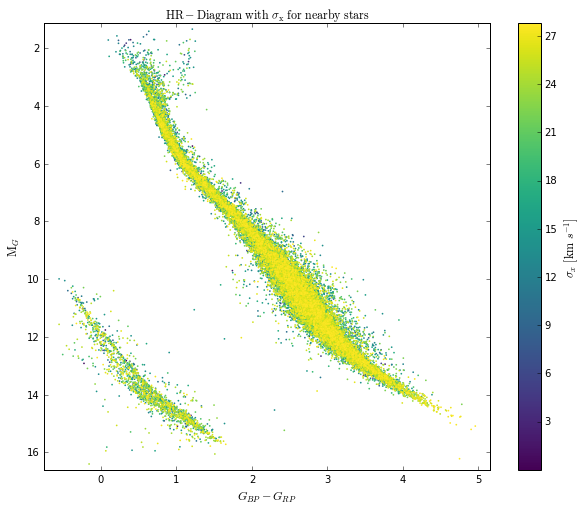

In [21]:
plot_HRD_veldisp(sample,G_mean,BP_RP,'x')

Say we would like to investigate the white dwarf section of the HRD, we can do this by applying additional cuts to our sample. We require that $G_{\mathrm{BP}}-G_{\mathrm{RP}}<2,\ \mathrm{and}\  G-10+5\log{\varpi} > 10+2.6(G_{\mathrm{BP}}-G_{\mathrm{RP}})$.

In [31]:
wd_cuts = [BP_RP_raw.value>2, G_mean_raw.value-10+5*np.log10(parallax_raw.value)<10+2.6*BP_RP_raw.value]

wd_sample, wd_G_mean, wd_BP_RP = apply_cuts(sample,G_mean,BP_RP,additional_cuts = wd_cuts)

print('This cut removed',len(sample)-len(wd_sample),'stars')
print('The new sample contains',len(wd_sample),'stars')

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


This cut removed 1083002 stars
The new sample contains 17398 stars


In [32]:
def plot_HRD_wd(sample,G_mean,BP_RP,base_sample=[]):
    
    """Function that given a sample and its G and BP_RP magnitudes provides an H-R diagram with the density of stars
    provided using a colormap. The density is computed using a Gaussian KDE"""
    
    parallax = sample.distance.to(u.mas,equivalencies=u.parallax())
    
    Gvals = G_mean.value+5*np.log10(parallax.value)-10
    
    xmin = BP_RP.value.min()-0.2
    xmax = BP_RP.value.max()+0.2
    ymin = Gvals.min()-0.2
    ymax = Gvals.max()+0.2
    
    xbins = np.arange(BP_RP.value.min(),BP_RP.value.max()+0.1,0.1)
    ybins = np.arange(Gvals.min(),Gvals.max()+0.3,0.3)
    
#     xc = (xbins[1:]+xbins[:-1])/2
#     yc = (ybins[1:]+ybins[:-1])/2

    dsty = fast_kde(BP_RP,Gvals,sample=True)[2]
        
    idx = dsty.argsort()
    
    xvals, yvals, zvals = BP_RP[idx],Gvals[idx],dsty[idx]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('$\mathrm{HR-Diagram\ of\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    ax.plot([-0.39,0.76],[10.48,14.55],'r-',lw=2)
    ax.plot([0.50,1.36],[13.65,15.3],'b-',lw=2)
    
    stars = ax.scatter(xvals,yvals,c=zvals,edgecolor='',s=5,cmap=plt.cm.get_cmap('inferno'))
    cb = plt.colorbar(stars)
    cb.set_label('$\mathrm{Number\ density\ of\ stars}$',size='large')
    
    plt.show()
    
    return

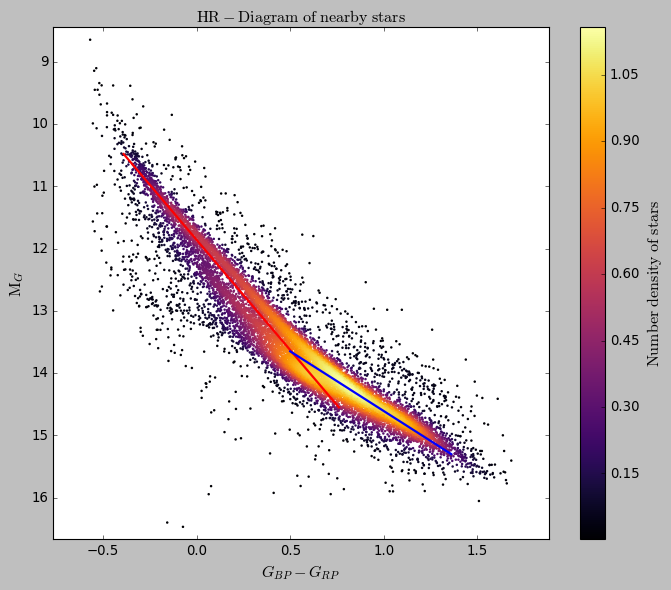

In [291]:
plot_HRD_wd(wd_sample,wd_G_mean,wd_BP_RP)

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


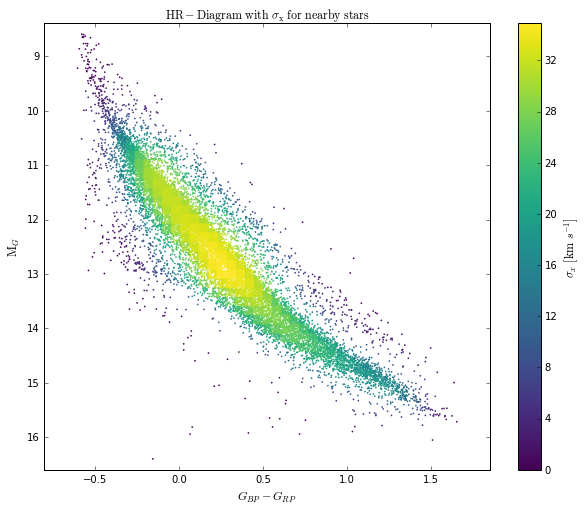

In [33]:
plot_HRD_veldisp(wd_sample,wd_G_mean,wd_BP_RP,'x')

In [34]:
wd_line1_x = [-0.39,0.76]
wd_line1_y = [10.48,14.55]

wd_line2_x = [0.50,1.36]
wd_line2_y = [13.65,15.3]

a,b = np.polyfit(wd_line1_x,wd_line1_y,1)
c,d = np.polyfit(wd_line2_x,wd_line2_y,1)

wd_parallax = wd_sample.distance.to(u.mas,equivalencies=u.parallax())

wd_Gvals = wd_G_mean.value+5*np.log10(wd_parallax.value)-10

wd_cuts_top = [wd_Gvals > a*wd_BP_RP.value +b, wd_Gvals > c*wd_BP_RP.value+d]
wd_cuts_top[0][wd_BP_RP.value>=0.5] = False
wd_cuts_top[1][wd_BP_RP.value<0.5] = False

wd_cuts_bot = [wd_Gvals < a*wd_BP_RP.value +b, wd_Gvals < c*wd_BP_RP.value+d]
wd_cuts_bot[0][wd_BP_RP.value >=0.5] = False
wd_cuts_bot[1][wd_BP_RP.value <0.5] = False

# [np.argwhere(i).shape for i in wd_cuts_top]

# wd_cuts_bot = [wd_Gvals > a*wd_BP_RP.value+b, wd_Gvals > c*wd_BP_RP.value+d]

In [35]:
wd_top, wd_G_mean_top, wd_BP_RP_top = apply_cuts(wd_sample,wd_G_mean,wd_BP_RP,additional_cuts = wd_cuts_top)
wd_bot, wd_G_mean_bot, wd_BP_RP_bot = apply_cuts(wd_sample,wd_G_mean,wd_BP_RP,additional_cuts = wd_cuts_bot)

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


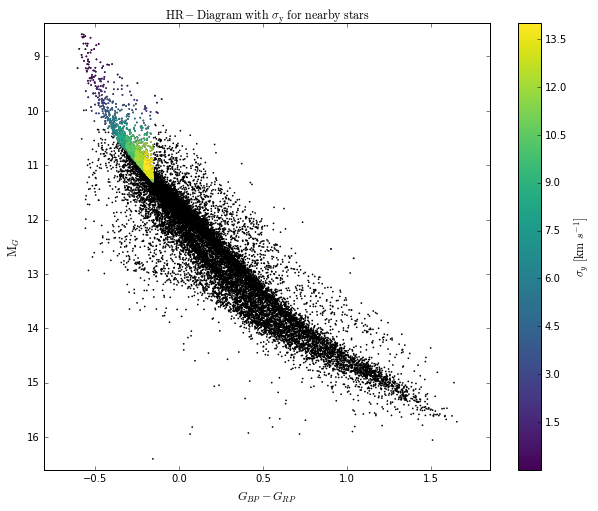

In [36]:
plot_HRD_veldisp(wd_sample,wd_G_mean,wd_BP_RP,'y',wd_cuts_top)

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


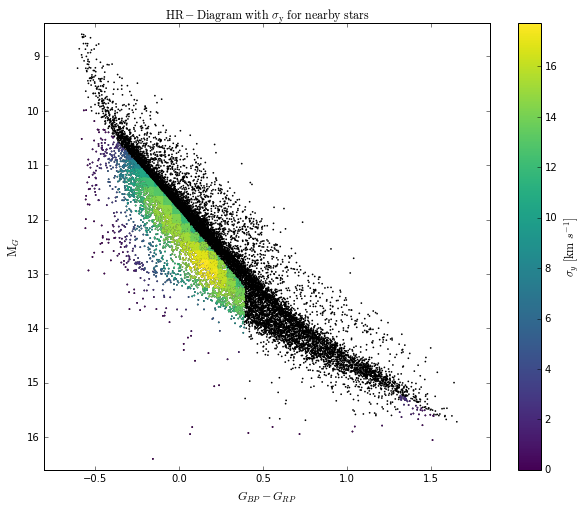

In [37]:
plot_HRD_veldisp(wd_sample,wd_G_mean,wd_BP_RP,'y',wd_cuts_bot)

In [155]:
wd_idx_mask = np.in1d(G_mean_raw.value,wd_G_mean.value,)

wd_idx = np.argwhere(wd_idx_mask)

<function matplotlib.pyplot.show(*args, **kw)>

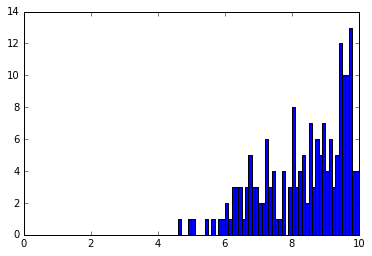

In [156]:
fix,ax = plt.subplots()
ax.hist(parallax_over_error[wd_idx],bins=100,range=(0,10))
plt.show


In [130]:
indlist = np.concatenate([np.ravel(np.argwhere(~np.isnan(G_mean))),np.ravel(np.argwhere(~np.isnan(BP_RP)))]) 

notnan = np.unique(indlist)

parallax = sample[notnan].distance.to(u.mas,equivalencies=u.parallax())

G_meanp, BP_RPp = G_mean[notnan], BP_RP[notnan]

In [10]:
datfil = "'gaiadr2_25pc.fits\'\n"